In [167]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas


In [168]:
def getDataset():
    #import dataset
    raw = fetch_california_housing(as_frame=True)
    
    #get input and output
    X = raw.data.values
    X = np.array(X,dtype='float32')
    np.apply_along_axis(standardize,axis=1,arr=X)
    Y = raw.target.values
    Y = np.array(Y,dtype='float32')
    n = len(X)
    r = 0.1
    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=1-r)
    
    x_val = x_train[int(len(x_train)*r):]
    part_x_train = x_train[:int(len(x_train)*r)]
    y_val = y_train[int(len(y_train)*r):]
    part_y_train = y_train[:int(len(y_train)*r)]
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(part_x_train),torch.from_numpy(part_y_train))
    valid_data = torch.utils.data.TensorDataset(torch.from_numpy(x_val),torch.from_numpy(y_val))
    test_data =  torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))

    return train_data,valid_data,test_data,y_test

In [169]:
getDataset()

(<torch.utils.data.dataset.TensorDataset at 0x7f8aa225ac90>,
 array([0.612, 2.5  , 2.436, ..., 3.663, 1.485, 2.183], dtype=float32))

In [170]:
def standardize(arr):
    arr[0] = (abs(arr[0]) - 3.870671003)/1.899821718
    arr[1] = (abs(arr[1]) - 28.63948643)/12.58555761
    arr[2] = (abs(arr[2]) - 5.428999742)/2.474173139
    arr[3] = (abs(arr[3]) - 1.09667515)/0.473910857
    arr[4] = (abs(arr[4]) - 1425.476744)/1132.462122
    arr[5] = (abs(arr[5]) - 3.070655159)/10.38604956
    arr[6] = (abs(arr[6]) - 35.63186143)/2.135952397
    arr[7] = (abs(arr[7]) - 119.5697045)/2.003531724

In [171]:
class RegularDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(RegularDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
         

In [172]:
class GBDropOut(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.scalar = 1/((self.group_size-1)/self.group_size)
        
    def forward(self,x):
        if self.training:
            scalar_mask = torch.full(x.size(),self.scalar)
            size=torch.Size([int(len(x)/self.group_size),])
            indexes_to_mask = torch.randint(0,self.group_size,size)
            index=0
            for itm in indexes_to_mask:
                scalar_mask[index+itm]=0
                index+=self.group_size 

            x = torch.multiply(x,scalar_mask)
            # print(x.requires_grad)
            return x
        else:
            return x


In [173]:
class GBDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(GBDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = GBDropOut(group_size=kwargs['group_size'])
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = GBDropOut(group_size=kwargs['group_size'])
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = GBDropOut(group_size=kwargs['group_size'])
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
        
 

In [174]:
class InverseBDO(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        # self.scalar = 1/((self.group_size-1)/self.group_size)
        
    def forward(self,x):
        if self.training:
            scalar_mask = torch.zeros(x.size())
            size=torch.Size([int(len(x)/self.group_size),])
            indexes_to_mask = torch.randint(0,self.group_size,size)
            index=0
            for itm in indexes_to_mask:
                scalar_mask[index+itm]=group_size
                index+=self.group_size 

            x = torch.multiply(x,scalar_mask)
            # print(x.requires_grad)
            return x
        else:
            return x

In [175]:
class InverseGbdoModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(InverseGbdoModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = InverseBDO(group_size=kwargs['group_size'])
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = InverseBDO(group_size=kwargs['group_size'])
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = InverseBDO(group_size=kwargs['group_size'])
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
        
 

In [176]:
def train(dataset, mdl, optm, loss_func):
    mdl.train(True)
    running_loss=0
    count=0
    for x,y in dataset:
        optm.zero_grad()
        output = mdl(x)
    
        training_loss = loss_func(output, torch.unsqueeze(y,0))
        training_loss.backward()
        
        optm.step()
        
        running_loss += training_loss.item()
        count+=1
        
    return running_loss/count
        
def validate(dataset, mdl, loss_func):
    mdl.eval()
    running_val_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            validation_loss = loss_func(output, torch.unsqueeze(y,0))
            running_val_loss += validation_loss.item()
            count+=1
            
    return running_val_loss/count
        
def predict(dataset, mdl,loss_func):
    mdl.eval()
    predictions=[]
    test_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            test_loss+=loss_func(output,torch.unsqueeze(y,0))
            predictions.append(float(output))
            count+=1
    return predictions,(test_loss/count)
        


In [177]:
def train_and_test_dropout(training,validation,testing,epochs,dropout_rate):
    DO_model = RegularDropOutModel(dropout_rate=dropout_rate)
    DO_optimizer = torch.optim.SGD(DO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        loss = train(training,DO_model,DO_optimizer,loss_fn)
        print(loss)
        valid_loss = validate(validation,DO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,DO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [178]:
def train_and_test_gb_dropout(training,validation,testing,epochs,group_size):
    GBDO_model = GBDropOutModel(group_size=group_size)
    GBDO_optimizer = torch.optim.SGD(GBDO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        loss = train(training,GBDO_model,GBDO_optimizer,loss_fn)
        print(loss)
        valid_loss = validate(validation,GBDO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,GBDO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [179]:
def train_and_test_inverse_gbdo(training,validation,testing,epochs,group_size):
    Inverse_GBDO_model = InverseGbdoModel(group_size=group_size)
    Inverse_GBDO_optimizer = torch.optim.SGD(Inverse_GBDO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        loss = train(training,Inverse_GBDO_model,Inverse_GBDO_optimizer,loss_fn)
        print(loss)
        valid_loss = validate(validation,Inverse_GBDO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,Inverse_GBDO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [180]:
def makeGraph(loss, val_loss,y_hat,y_true,epochs):
    fig, (ax11,ax12) = plt.subplots(2,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,loss,'bo',label='Training Loss')
    ax11.plot(epochs,val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    plt.show()

In [181]:
def makeGraphs_2(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,y_true,epochs):
    fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Inverse Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    plt.show()

In [182]:
def makeGraphs_3(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,inverse_loss, inverse_val_loss,inverse_y_hat,y_true,epochs):
    fig, ((ax11,ax21,ax31),(ax12,ax22,ax32)) = plt.subplots(2,3)
    fig.set_figwidth(18)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    
    ax31.set_title('Inverse Group Based DropOut')
    ax31.plot(epochs,inverse_loss,'bo',label='Training Loss')
    ax31.plot(epochs,inverse_val_loss,'r',label='Validation Loss')
    ax31.set(xlabel='Epochs',ylabel='Loss')
    ax31.set_ylim(0.1,1.5)
    ax31.legend()
   
    ax32.scatter(y_true,inverse_y_hat,s=2)
    ax32.plot(x_temp, y_temp, 'r')
    ax32.set(xlabel='Actual',ylabel='Predicted')
    ax32.set_ylim(-.25,5.5)
    ax32.set_xlim(-.25,5.5)
    
    
    
    plt.show()

In [ ]:
global first_layer_size
global second_layer_size
global third_layer_size
training_data, valid_data, test_data, y_true = getDataset()

epochs = range(1500)
dropout_rate = 0.25
group_size=4
first_layer_size = 32
second_layer_size = 32
third_layer_size = 16

t_loss_dropout, v_loss_dropout, tst_loss_dropout, y_pred_dropout = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_gbdo,    v_loss_gbdo,    tst_loss_gbdo,    y_pred_gbdo    = train_and_test_gb_dropout(training_data,valid_data,test_data,epochs,group_size)
# t_loss_inverse,    v_loss_inverse,    tst_loss_inverse,    y_pred_inverse    = train_and_test_inverse_gbdo(training_data,valid_data,test_data,epochs,group_size)

print("GBDO Test Loss = ",tst_loss_gbdo)
# print("I_GBDO Test Loss = ", tst_loss_inverse)
print("  DO Test Loss = ",tst_loss_dropout)

# makeGraph(t_loss_dropout,v_loss_dropout,y_pred_dropout,y_true,epochs)
makeGraphs_2(t_loss_dropout,v_loss_dropout,y_pred_dropout,t_loss_gbdo,v_loss_gbdo,y_pred_gbdo,y_true,epochs)
# makeGraphs_2(t_loss_dropout,v_loss_dropout,y_pred_dropout,t_loss_inverse,v_loss_inverse,y_pred_inverse,y_true,epochs)
# makeGraphs_3(t_loss_dropout,v_loss_dropout,y_pred_dropout,t_loss_gbdo,v_loss_gbdo,y_pred_gbdo,t_loss_inverse,v_loss_inverse,y_pred_inverse,y_true,epochs)


1.2847898293194588
1.1541034229407054
1.1482299116111163
1.1676230175449056
1.1441503517731
1.1254655163506824
1.1612536404042915
1.1254438434097016
1.0868881672910893
1.0910879451025766
1.123942399909954
1.1089450053992038
1.106151645069449
1.106024954562968
1.103816353037641
1.0993302693842426
1.0832318939451617
1.087664145645346
1.1396589795843381
1.0966268227468425
1.0946649509421051
1.080408823918492
1.0810204839056416
1.0834589449865606
1.0719260494910823
1.0767351472219013
1.0837846592785532
1.088852653473954
1.0776964075389823
1.0769815528985895
1.08115908841447
1.0627295461629207
1.060991221442422
1.0747915370025598
1.0917519711587622
1.0654709823938615
1.0524782125556122
1.053125350226376
1.0541799734966704
1.0844368605435282
1.0727860202162456
1.0302829221470426
1.058965380647928
0.9992342573024862
1.0134416194604394
1.0124451105681165
0.9933960046036571
0.9798426189859437
1.0025401555112605
0.9169160523695574
0.918085660004163
0.8076403878116146
0.8425284866135035
0.6952795

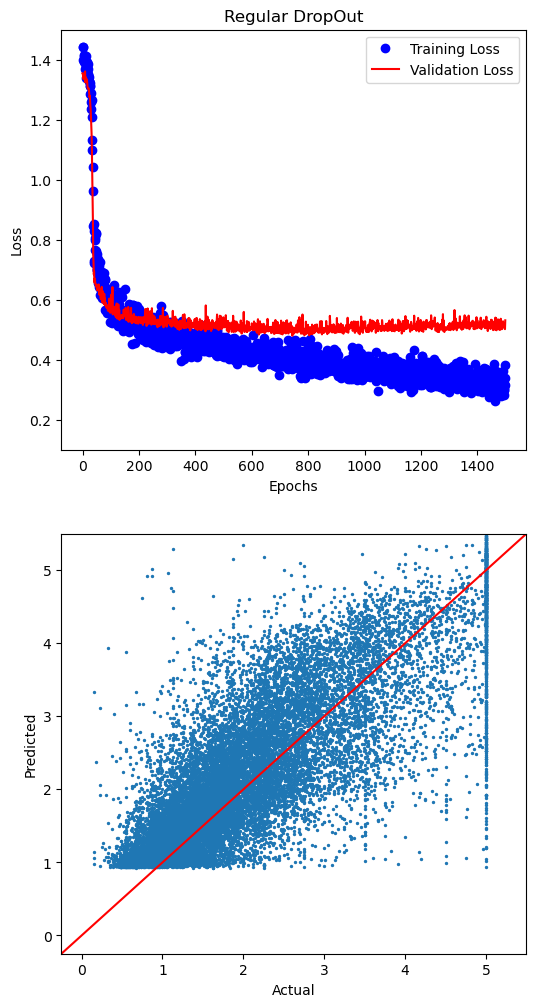

GBDO Test Loss =  tensor(0.5244)


In [186]:
makeGraph(t_loss_dropout,v_loss_dropout,y_pred_dropout,y_true,epochs)
print("GBDO Test Loss = ",tst_loss_gbdo)